In [2]:
#PLAN 

#load in storm dataframe

#load in article dataframe 

#load in topics

#merge everything 
#should be able to steal from other notebooks 

#for each storm: 
    #get time series without storm
    #compute daily and weekly topic levels 


In [3]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
from ast import literal_eval

/opt/anaconda/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
N_TOPICS = 30


STORMS_PATH  = "/shared/3/projects/newsDiffusion/data/processed/stormDfs/20000_90_storms.tsv"
ARTICLES_PATH = "/shared/3/projects/newsDiffusion/data/processed/fullDataWith20000.tsv"
EMBEDS_PATH = "/shared/3/projects/newsDiffusion/data/processed/articleEmbeddings/embeddings.pkl"

stormsDf = pd.read_csv(STORMS_PATH, sep="\t")
artDf = pd.read_csv(ARTICLES_PATH, sep="\t")

artDf = artDf.drop(columns=["Unnamed: 0"])
stormsDf = stormsDf.drop(columns=["Unnamed: 0"])

<ipython-input-4-99570a450603>:9: DtypeWarning: Columns (4,5,12,13,15,16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  artDf = pd.read_csv(ARTICLES_PATH, sep="\t")


In [5]:
#should be fine to leave all articles in, because we are just grabbing right before the storm starts 

In [6]:
#a dictionary so we can get the embeddings we need quickly 
#embeddingsDict = embeddingsDf.set_index("key").to_dict(orient="index")
embedsFile = open(EMBEDS_PATH, "rb")
embeddingsDict = pickle.load(embedsFile)

In [7]:
SCOL = "20000_90"

In [8]:
stormsDf[SCOL + "_storm"] = True

In [9]:
merged = pd.merge(artDf, stormsDf.drop(columns=[SCOL]), on="key", how="left")

In [10]:
#load in our topics 
cols = ["dummy", "key"] + list(range(0, N_TOPICS))
docTopics = pd.read_csv("/shared/3/projects/newsDiffusion/data/interim/topicModelling/30/doc_topics.txt", sep="\t", names=cols)

#load in the words associated with topics 
topicWords = pd.read_csv("/shared/3/projects/newsDiffusion/data/interim/topicModelling/30/topic_keys.txt", sep="\t", \
                         names=["topicNum", "dummy", "words"], usecols=["topicNum", "words"])

merged = pd.merge(merged, docTopics.drop(columns=["dummy"]), on="key", how="left")

In [11]:
SCOL = "20000_90"

In [12]:
merged["date"] = pd.to_datetime(merged["date"])

In [13]:
from tqdm import tqdm

In [14]:
merged[SCOL + "_storm"] = merged[SCOL + "_storm"].fillna(False)

In [15]:
def maxTopics(inRow): 
    maxElem = 0
    maxTopic = 0 
    for i, item in enumerate(inRow): 
        if item > maxElem: 
            maxElem = item
            maxTopic = i 
            
    #to test we can run: return (maxTopic, maxElem)
    return maxTopic

In [17]:
ENT_PATH = "/shared/3/projects/newsDiffusion/data/interim/NEREmbedding/NERIndexPickled.pkl"

#this is the df with our inverted index in it
entDf = pd.read_pickle(ENT_PATH)

KeyboardInterrupt: 

In [ ]:
entDf = entDf[["key", "entity"]].groupby("key").agg(set)

In [ ]:
#TODO: we want to write a function that removes any article in beforeDf or afterDf that has a similarity score of .8 or 
#greater with any article in stormRows 

#take in the keys for the storm rows and the 
#keys for the rows corresponding to time period before and after 
def getStormSims(stormKeys, otherKeys): 
    simList = []
    lKeyList = []
    rKeyList = []


    #within each list of article keys, consider the unique pairs 
    #and get their cosine similarities 
    #for i in range(0, len(entGroup)): 
    stormMat = np.matrix([embeddingsDict[key]["embedding"] for key in stormKeys])
    otherMat = np.matrix([embeddingsDict[key]["embedding"] for key in otherKeys])
    pairSims = cosine_similarity(stormMat, otherMat).flatten()
    entGroup = np.array(entGroup)

    greaterThan = np.where(pairSims > .8)
    simList.append(pairSims[greaterThan])

    #get the equivalent row and column indices to what we have in the flattened array 
    left = [math.floor(index / len(entGroup)) for index in greaterThan[0]]
    right = [index % len(entGroup) for index in greaterThan[0]]

    #get the keys corresponding to the elements we selected from the list 
    lKeyList.append(entGroup[left])
    rKeyList.append(entGroup[right])
    

#TODO: also measure whether topic diversity decreases 

In [ ]:
from collections import Counter

In [ ]:
#calculate entropy from a list of occurences in diff categories
def entropy(inList): 
    ics = []
    for prob in inList: 
        ics.append(prob * np.log(prob))
    return -sum(ics)

In [ ]:
#NEW ANALYSIS, aggregate at each outlet's average topic percentage 
pd.options.mode.chained_assignment = None  # default='warn'

#for results/analysis dataframes
mResults = []
regDfs = []
regDfsNoStorms = []
entDfs = []

#for each storm 
stormClusts = list(stormsDf[SCOL].unique())
for clustNum in tqdm(stormClusts): 
    stormRows = merged[merged[SCOL] == clustNum]
    fDay = min(stormRows["date"])
    bCutoff = fDay - np.timedelta64(14, "D")
    aCutoff = fDay + np.timedelta64(14, "D")
    
    stormOutlets = list(stormRows["source"].unique()) 
    
    #p for patrol
    pSources = literal_eval(stormRows["20000_90_storm_source"].iloc[0])
    
    #get all coverage from two weeks before and two weeks after first day
    #and keep the storm rows removed
    beforeDf = merged[(merged["source"].isin(stormOutlets)) & (merged["date"] >= bCutoff) & (merged["date"] < fDay)]
    
    afterDf = merged[(merged["source"].isin(stormOutlets)) & (merged["date"] <= aCutoff) & (merged["date"] >= fDay )]
    afterDfNoStorms = merged[(merged["source"].isin(stormOutlets)) & (merged[SCOL + "_storm"] == False) & (merged["date"] <= aCutoff) & (merged["date"] >= fDay )]
    
    #get the topic that the storm is "about"
    stormTopic =  Counter(list(stormRows[list(range(0, N_TOPICS))].apply(maxTopics, axis=1))).most_common()[0][0]
    
    #set up topic proportion regression model! 
    beforeDf["rDate"] = (beforeDf["date"] - fDay) / np.timedelta64(1, "D")
    beforeDf["treated"] = "0"

    #after df with storms included 
    afterDf["rDate"] = (afterDf["date"] - fDay) / np.timedelta64(1, "D")
    afterDf["treated"] = "1"
    
    #after df with storm articles removed 
    afterDfNoStorms["rDate"] = (afterDfNoStorms["date"] - fDay) / np.timedelta64(1, "D")
    afterDfNoStorms["treated"] = "1"
    
    regCols = ["rDate", "treated", stormTopic]
    regDf = pd.concat([beforeDf[regCols], afterDf[regCols]]) 
    regDf["stormNum"] = clustNum
    regDf = regDf.rename(columns={stormTopic:"topicLevel"}) 
    regDf["stormSize"] = len(stormRows)
    
    regDfNoStorms = pd.concat([beforeDf[regCols], afterDfNoStorms[regCols]]) 
    regDfNoStorms["stormNum"] = clustNum
    regDfNoStorms = regDfNoStorms.rename(columns={stormTopic:"topicLevel"}) 
    regDfNoStorms["stormSize"] = len(stormRows)
    
    regDfs.append(regDf)
    regDfsNoStorms.append(regDfNoStorms)

In [ ]:
#this version has storms left in!
pooledDf = pd.concat(regDfs)
pooledDf.shape
pooledDf["topicLevel"] = pooledDf["topicLevel"] * 100

#get average number of topics in the before storm period 
topicNormDf = pooledDf.groupby(["stormNum", "treated"]).agg(list).reset_index()
topicNormDf = topicNormDf[topicNormDf["treated"] == "0"]
topicNormDf["meanLevel"] = topicNormDf["topicLevel"].apply(np.mean)

#center topic levels around average of before storm period 
pooledDf = pd.merge(pooledDf, topicNormDf[["stormNum", "meanLevel"]], on="stormNum", how="left") 
pooledDf["normLevel"] = (pooledDf["topicLevel"] - pooledDf["meanLevel"]) + 100

In [ ]:

#save df 
wStormsDf = pooledDf.copy(deep=True)

In [ ]:
#this `aversion has storm articles taken out!
pooledDf = pd.concat(regDfsNoStorms)
pooledDf.shape
pooledDf["topicLevel"] = pooledDf["topicLevel"] * 100

#get average number of topics in the before storm period 
topicNormDf = pooledDf.groupby(["stormNum", "treated"]).agg(list).reset_index()
topicNormDf = topicNormDf[topicNormDf["treated"] == "0"]
topicNormDf["meanLevel"] = topicNormDf["topicLevel"].apply(np.mean)

#center topic levels around average of before storm period 
pooledDf = pd.merge(pooledDf, topicNormDf[["stormNum", "meanLevel"]], on="stormNum", how="left") 
pooledDf["normLevel"] = (pooledDf["topicLevel"] - pooledDf["meanLevel"]) + 100

#save df 
noStormsDf = pooledDf.copy(deep=True)

In [ ]:
FIG_PATH = "/home/blitt/projects/localNews/reports/figures/drafts/"
PALETTE = ["#008837", "#7b3294"]

In [ ]:
wStormsDf.head()

In [ ]:
beforeLevel = np.mean(wStormsDf.loc[wStormsDf["treated"] == "0", "topicLevel"])

In [ ]:
fig, axs = plt.subplots(2, figsize=(5, 5))
sns.lineplot(data=wStormsDf, x="rDate", y="topicLevel", err_style="bars", ax=axs[0], \
             err_kws={"elinewidth":.7}, label="storm articles included", color=PALETTE[0], estimator="mean", n_boot=10)

#ax[0].errorbar(x, y_mean, error, color='tab:blue', ecolor='tab:blue')
sns.lineplot(data=noStormsDf, x="rDate", err_kws={"elinewidth":.7}, y="topicLevel", n_boot=10, err_style="bars", ax=axs[1], label="storm articles excluded", color=PALETTE[1], estimator="mean")

axs[0].set_title("Storm Topic Percentages Before & During Storms")
axs[0].set_xlabel("")
axs[0].set_ylabel("")
axs[0].set_ylim(4, 12)
axs[0].axvline(0, color="grey", alpha=.5, linestyle="dashed")
axs[0].axhline(beforeLevel, color="grey", alpha=.5, linestyle="dashed")
axs[0].set_xticks([])
#axs[0].set_xticklabels(None)

#axs[1].set_title("Change in Storm Topic Percentages Before and After Media Storms")
axs[1].set_xlabel("Day Relative to Storm")
axs[1].set_ylabel("")
axs[1].set_ylim(4, 12)
axs[1].axvline(0, color="grey", alpha=.5, linestyle="dashed")
axs[1].axhline(beforeLevel, color="grey", alpha=.5, linestyle="dashed")

fig.text(0.02, 0.5, "Average Topic %", va='center', rotation='vertical')

axs[0].legend(loc="lower right")
axs[1].legend(loc="lower right")
#plt.tight_layout()
#caption idea 

#plt.savefig(FIG_PATH + "topicSeriesStacked.pdf", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(1, figsize=(5, 3))
sns.lineplot(data=wStormsDf, x="rDate", y="topicLevel", err_style="bars", ax=ax, \
             err_kws={"elinewidth":.7}, label="storm articles included", color=PALETTE[0], estimator="mean", n_boot=100)

sns.lineplot(data=noStormsDf, x="rDate", err_kws={"elinewidth":.7}, y="topicLevel", err_style="bars", ax=ax, label="storm articles excluded", color=PALETTE[1], estimator="mean", n_boot=100)

ax.set_title("")
ax.set_xlabel("Day Relative to Storm", size=12)
ax.set_ylabel("Average Topic %", size=12)
ax.set_ylim(4.5, 7.51)
ax.axvline(-.03, color="grey", alpha=.3, linestyle="dashed")
ax.axhline(beforeLevel, color="grey", alpha=.3, linestyle="dashed")
ax.legend(loc="lower right")

plt.savefig(FIG_PATH + "StormOutletsTopicSeries.pdf", bbox_inches="tight")

In [ ]:
#get diff from mean coverage before to peak after 
#diff of 1.58%
stormDiff = np.mean(wStormsDf.loc[wStormsDf["rDate"] == 1, "topicLevel"]) - np.mean(wStormsDf.loc[wStormsDf["rDate"] < 0, "topicLevel"]) 
print(stormDiff)

#diff of 1.10%
nonStormDiff = np.mean(noStormsDf.loc[noStormsDf["rDate"] == 1, "topicLevel"]) - np.mean(noStormsDf.loc[noStormsDf["rDate"] < 0, "topicLevel"]) 
print(nonStormDiff)

In [ ]:
#punch in here 

In [291]:
#day 1 - day 15: increase of 1.97%
stormDiff = np.mean(wStormsDf.loc[wStormsDf["rDate"] == 1, "topicLevel"]) - np.mean(wStormsDf.loc[wStormsDf["rDate"] == -14, "topicLevel"]) 
print(stormDiff)

#day 1 - day 15: 
nonStormDiff = np.mean(noStormsDf.loc[noStormsDf["rDate"] == 1, "topicLevel"]) - np.mean(noStormsDf.loc[noStormsDf["rDate"] == -14, "topicLevel"]) 
print(nonStormDiff)

1.9721365855190438
1.4938895730964195


In [180]:
monthFrame = merged[(merged["date"] >= "01-01-2020") & (merged["date"] <= "02-01-2020")]

In [186]:
dailyAvgs = monthFrame[["date", "source"] + list(range(0, 30))].groupby("date").agg(np.mean).reset_index()

In [130]:
pd.options.mode.chained_assignment = None  # default='warn'

#for results/analysis dataframes
mResults = []
regDfs = []
entDfs = []

#for each storm 
stormClusts = list(stormsDf[SCOL].unique())
for clustNum in tqdm(stormClusts): 
    stormRows = merged[merged[SCOL] == clustNum]
    fDay = min(stormRows["date"])
    bCutoff = fDay - np.timedelta64(7, "D")
    aCutoff = fDay + np.timedelta64(7, "D")
    
    stormOutlets = list(stormRows["source"].unique()) 
    
    #p for patrol
    pSources = literal_eval(stormRows["20000_90_storm_source"].iloc[0])
    
    #get all coverage from two weeks before and two weeks after first day
    #and keep the storm rows removed
    beforeDf = merged[(merged["source"].isin(pSources)) & (merged["date"] >= bCutoff) & (merged["date"] < fDay)]
    #beforeDf = merged[(merged["date"] >= bCutoff) & (merged["date"] < fDay)]
    
    #afterDf = merged[(merged["date"] <= aCutoff) & (merged["date"] > fDay ) & (merged[SCOL + "_storm"] == False)]
    afterDf = merged[(merged["source"].isin(pSources)) & (merged[SCOL + "_storm"] == False) & (merged["date"] <= aCutoff) & (merged["date"] >= fDay )]
    #afterDf = merged[(merged[SCOL + "_storm"] == False) & (merged["date"] <= aCutoff) & (merged["date"] >= fDay )]
    
    #beforeSums = beforeDf[list(range(0, N_TOPICS))].apply(np.nansum)
    #afterSums = afterDf[list(range(0, N_TOPICS))].apply(np.nansum)
    
    """
    this is if we want to use only articles about that topic 
    #topic distributions from before 
    beforeCounts = Counter(list(beforeDf[list(range(0, N_TOPICS))].apply(maxTopics, axis=1)))

    #topic distribtions from after 
    afterCounts = Counter(list(afterDf[list(range(0, N_TOPICS))].apply(maxTopics, axis=1)))
    """

    #get the topic that the storm is "about"
    stormTopic =  Counter(list(stormRows[list(range(0, N_TOPICS))].apply(maxTopics, axis=1))).most_common()[0][0]
    
    #set up topic proportion regression model! 
    beforeDf["rDate"] = (beforeDf["date"] - fDay) / np.timedelta64(1, "D")
    beforeDf["DoW"] = beforeDf["date"].dt.dayofweek
    beforeDf["treated"] = "0"

    afterDf["rDate"] = (afterDf["date"] - fDay) / np.timedelta64(1, "D")
    afterDf["DoW"] = afterDf["date"].dt.dayofweek

    afterDf["treated"] = "1"

    regCols = ["rDate", "DoW", "treated", stormTopic]
    regDf = pd.concat([beforeDf[regCols], afterDf[regCols]]) 
    regDf["DoW"] = regDf["DoW"].astype(object)
    regDf["stormNum"] = clustNum
    regDf = regDf.rename(columns={stormTopic:"topicLevel"}) 
    regDf["stormSize"] = len(stormRows)
    
    #regDf = regDf.rename(columns={stormTopic:"c" + str(stormTopic)})

    mod = smf.ols(formula="topicLevel ~ DoW + rDate + treated + rDate:treated", data=regDf)
    res = mod.fit()
    params = (stormTopic, clustNum, res.params["treated[T.1]"], res.pvalues["treated[T.1]"], res.params["rDate"], res.pvalues["rDate"], res.params["rDate:treated[T.1]"], res.pvalues["rDate:treated[T.1]"])
    
    #append topic prop. model results 
    mResults.append(params)
    regDfs.append(regDf)
    
    #now do entropy calculations and get data in format for regression 
    beforeProbs = beforeDf[list(range(0, N_TOPICS)) + ["rDate"]].groupby("rDate").agg(sum).apply(lambda x: x / sum(x), axis=1)
    beforeEnt = beforeProbs.apply(entropy, axis=1)

    afterProbs = afterDf[list(range(0, N_TOPICS)) + ["rDate"]].groupby("rDate").agg(sum).apply(lambda x: x / sum(x), axis=1)
    afterEnt = afterProbs.apply(entropy, axis=1)

    entDf = pd.concat([afterEnt, beforeEnt]).reset_index()
    entDf.columns = ["rDate", "entropy"]
    entDf["treated"] = entDf["rDate"] >= 0
    entDf["storm"] = clustNum
    entDf["stormSize"] = len(stormRows)
    
    #just do a pooled model here.. 
    #probably not enough observations to get good unpooled model 
    entDfs.append(entDf)
    
    

  7%|▋         | 7/98 [00:06<01:23,  1.10it/s]


KeyboardInterrupt: 

In [ ]:
mDf = pd.DataFrame(mResults)
mDf.columns = ["topic", "stormClust", "treated", "treated_p", "time", "time_p", "time:treated", "time:treated_p"]

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
sigDf = mDf[mDf["treated_p"] <= .05]
plt.hist(sigDf["treated"], bins=np.arange(-.10, .10, .01))
ax.set_xticks(np.arange(-.1, .1, .05))
plt.axvline(0, color="red")
plt.show()

print(f'average estimate for treatment is {np.mean(sigDf["treated"])}')

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.hist(mDf["treated"], bins=np.arange(-.10, .10, .01))
ax.set_xticks(np.arange(-.1, .1, .05))
plt.axvline(0, color="red")
plt.show()

print(f'average estimate for treatment is {np.mean(mDf["treated"])}')

In [ ]:
np.mean(mDf["treated_p"] < .05)

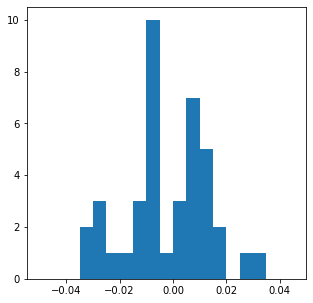

average estimate for time:treatment is -0.002941040003385775


In [255]:
fig, ax = plt.subplots(figsize=(5, 5))
sigDf = mDf[mDf["time:treated_p"] <= .05]
plt.hist(sigDf["time:treated"], bins=np.arange(-.05, .05, .005))
#ax.set_xticks(np.arange(-.1, .1, .05))
plt.show()

print(f'average estimate for time:treatment is {np.mean(sigDf["time:treated"])}')

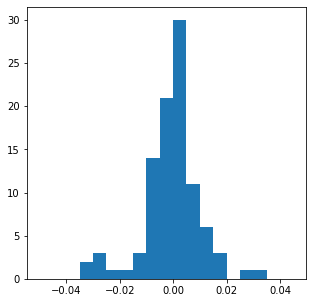

average estimate for time:treatment is -0.0005897262853504437


In [256]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.hist(mDf["time:treated"], bins=np.arange(-.05, .05, .005))
#ax.set_xticks(np.arange(-.1, .1, .05))
plt.show()

print(f'average estimate for time:treatment is {np.mean(mDf["time:treated"])}')

In [395]:
pooledDf = pd.concat(regDfs)

In [396]:
#easier to think in percents
pooledDf["topicLevel"] = pooledDf["topicLevel"] * 100

In [397]:
mod = smf.ols(formula="topicLevel ~ DoW + rDate + treated + rDate:treated", data=pooledDf)

res = mod.fit()
params = (stormTopic, clustNum, res.params["treated[T.1]"], res.pvalues["treated[T.1]"], res.params["rDate"], res.pvalues["rDate"], res.params["rDate:treated[T.1]"], res.pvalues["rDate:treated[T.1]"])


In [398]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             topicLevel   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     65.37
Date:                Sat, 17 Jun 2023   Prob (F-statistic):          8.29e-121
Time:                        11:48:01   Log-Likelihood:            -1.7566e+06
No. Observations:              412797   AIC:                         3.513e+06
Df Residuals:                  412787   BIC:                         3.513e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              7.8045      0.107     73.246      0.000       7.596       8.013
DoW[T.1]               0.0922      0.097      0.952      0.341      -0.098       0.282
DoW[T.2]               0.0924      0.096      0.959      0.338      -0.096       0.281
DoW[T.3]               0.0402      0.095      0.423      0.672      -0.146       0.227
DoW[T.4]              -0.3401      0.097     -3.524      0.000      -0.529      -0.151
DoW[T.5]              -0.2319      0.106     -2.186      0.029      -0.440      -0.024
DoW[T.6]              -0.2317      0.108     -2.142      0.032      -0.444      -0.020
treated[T.1]           0.9541      0.110      8.642      0.000       0.738       1.171
rDate                  0.1422      0.020      7.279      0.000       0.104       0.181
rDate:treated[T.1]    -0.2567      0.025    -10.265      0.000      -0.306      -0.208
==============================================================================
Omnibus:                   225613.286   Durbin-Watson:                   1.658
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1345544.546
Skew:                           2.710   Prob(JB):                         0.00
Kurtosis:                       9.990   Cond. No.                         37.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [399]:
mod = smf.ols(formula="topicLevel ~ DoW + treated + stormSize + treated:stormSize", data=pooledDf)

res = mod.fit()
#params = (stormTopic, clustNum, res.params["treated[T.1]"], res.pvalues["treated[T.1]"], res.params["rDate"], res.pvalues["rDate"], res.params["rDate:treated[T.1]"], res.pvalues["rDate:treated[T.1]"])

In [400]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             topicLevel   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     137.0
Date:                Sat, 17 Jun 2023   Prob (F-statistic):          2.61e-259
Time:                        11:48:22   Log-Likelihood:            -1.7563e+06
No. Observations:              412797   AIC:                         3.513e+06
Df Residuals:                  412787   BIC:                         3.513e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  8.2349      0.086     95.789      0.000       8.066       8.403
DoW[T.1]                   0.0588      0.097      0.608      0.543      -0.131       0.248
DoW[T.2]                   0.0528      0.096      0.548      0.584      -0.136       0.242
DoW[T.3]                   0.0133      0.095      0.140      0.889      -0.173       0.199
DoW[T.4]                  -0.3395      0.096     -3.533      0.000      -0.528      -0.151
DoW[T.5]                  -0.2044      0.106     -1.931      0.054      -0.412       0.003
DoW[T.6]                  -0.2267      0.108     -2.098      0.036      -0.438      -0.015
treated[T.1]               0.6585      0.078      8.440      0.000       0.506       0.811
stormSize                 -0.0028      0.000    -23.835      0.000      -0.003      -0.003
treated[T.1]:stormSize     0.0014      0.000      8.549      0.000       0.001       0.002
==============================================================================
Omnibus:                   225030.680   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1336528.145
Skew:                           2.703   Prob(JB):                         0.00
Kurtosis:                       9.963   Cond. No.                     4.25e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [404]:
stormSize = np.arange(50, 1000, 50)
baseEffect = .0066
baseTopicLevel = .10 

change = []
for size in stormSize:  
    change.append(.659 + (.0014*size))

Text(0, 0.5, 'Mean Increase in Storm Topic % Per Article')

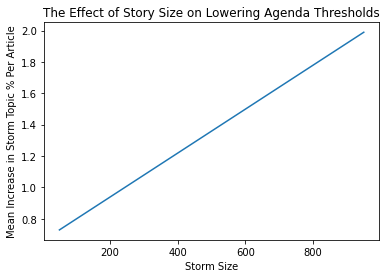

In [412]:
plt.plot(stormSize, change) 
plt.title("The Effect of Story Size on Lowering Agenda Thresholds")
plt.xlabel("Storm Size")
plt.ylabel("Mean Increase in Storm Topic % Per Article")

(array([  1.,   0.,   1.,   0.,   1.,   8.,  25., 148., 553., 727.]),
 array([1.2290937 , 1.43768359, 1.64627348, 1.85486338, 2.06345327,
        2.27204316, 2.48063305, 2.68922294, 2.89781283, 3.10640272,
        3.31499262]),
 <BarContainer object of 10 artists>)

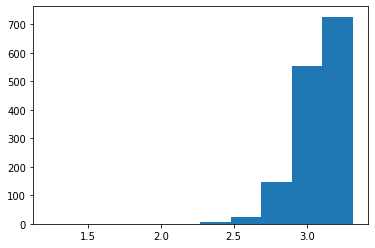

In [408]:
plt.hist(pEntDf["entropy"])

<Axes: xlabel='rDate', ylabel='entropy'>

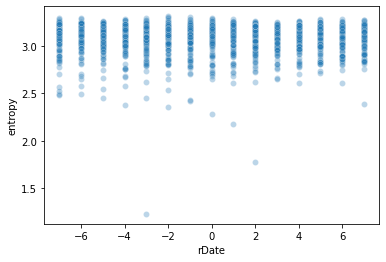

In [409]:
sns.scatterplot(x="rDate", y="entropy", data=pEntDf, alpha=.3)

In [411]:
#pooled entropy 
pEntDf = pd.concat(entDfs)
pEntDf["storm"] = pEntDf["storm"].astype(str)

#regression 
mod = smf.ols(formula="entropy ~ rDate +  treated + rDate:treated", data=pEntDf)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                entropy   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8127
Date:                Sat, 17 Jun 2023   Prob (F-statistic):              0.487
Time:                        11:54:38   Log-Likelihood:                 580.95
No. Observations:                1464   AIC:                            -1154.
Df Residuals:                    1460   BIC:                            -1133.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.0514      0.014    219.036      0.000       3.024       3.079
treated[T.True]           0.0157      0.018      0.898      0.369      -0.019       0.050
rDate                    -0.0041      0.003     -1.316      0.189      -0.010       0.002
rDate:treated[T.True]     0.0057      0.004      1.411      0.159      -0.002       0.014
==============================================================================
Omnibus:                      876.338   Durbin-Watson:                   0.565
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15686.542
Skew:                          -2.438   Prob(JB):                         0.00
Kurtosis:                      18.277   Cond. No.                         25.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [413]:
pEntDf

,rDate,entropy,treated,storm,stormSize
0,0.0,3.063510,True,359.0,93
1,1.0,3.094792,True,359.0,93
2,2.0,3.051465,True,359.0,93
3,3.0,3.145487,True,359.0,93
4,4.0,3.121644,True,359.0,93
...,...,...,...,...,...
10,-5.0,3.040854,False,295028.0,62
11,-4.0,2.944442,False,295028.0,62
12,-3.0,2.864051,False,295028.0,62
13,-2.0,2.916698,False,295028.0,62


In [414]:
#pooled entropy 
pEntDf = pd.concat(entDfs)
pEntDf["storm"] = pEntDf["storm"].astype(str)

#regression 
mod = smf.ols(formula="entropy ~ treated +  stormSize + treated:stormSize", data=pEntDf)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                entropy   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     50.29
Date:                Sat, 17 Jun 2023   Prob (F-statistic):           6.28e-31
Time:                        11:58:14   Log-Likelihood:                 651.71
No. Observations:                1464   AIC:                            -1295.
Df Residuals:                    1460   BIC:                            -1274.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     3.0100      0.009    342.212      0.000       2.993       3.027
treated[T.True]               0.0119      0.012      0.988      0.323      -0.012       0.035
stormSize                     0.0003   3.11e-05      8.908      0.000       0.000       0.000
treated[T.True]:stormSize -3.203e-05   4.25e-05     -0.753      0.451      -0.000    5.14e-05
==============================================================================
Omnibus:                      938.481   Durbin-Watson:                   0.613
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20795.711
Skew:                          -2.608   Prob(JB):                         0.00
Kurtosis:                      20.712   Cond. No.                     1.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [451]:
#try when leaving the articles IN 
pd.options.mode.chained_assignment = None  # default='warn'

#for results/analysis dataframes
mResults = []
regDfs = []
entDfs = []

#for each storm 
stormClusts = list(stormsDf[SCOL].unique())
for clustNum in tqdm(stormClusts): 
    stormRows = merged[merged[SCOL] == clustNum]
    fDay = min(stormRows["date"])
    bCutoff = fDay - np.timedelta64(7, "D")
    aCutoff = fDay + np.timedelta64(7, "D")
    
    stormOutlets = list(stormRows["source"].unique()) 
    
    #p for patrol
    pSources = literal_eval(stormRows["20000_90_storm_source"].iloc[0])
    
    #get all coverage from two weeks before and two weeks after first day
    #and keep the storm rows IN
    #for patrol sources do merged["source"].isin(pSources)) 
    beforeDf = merged[merged["source"].isin(pSources) & (merged["date"] >= bCutoff) & (merged["date"] < fDay)]
    afterDf = merged[merged["source"].isin(pSources) & (merged["date"] <= aCutoff) & (merged["date"] >= fDay )]

    #get the topic that the storm is "about"
    stormTopic =  Counter(list(stormRows[list(range(0, N_TOPICS))].apply(maxTopics, axis=1))).most_common()[0][0]
    
    #set up topic proportion regression model! 
    beforeDf["rDate"] = (beforeDf["date"] - fDay) / np.timedelta64(1, "D")
    beforeDf["DoW"] = beforeDf["date"].dt.dayofweek
    beforeDf["treated"] = "0"

    afterDf["rDate"] = (afterDf["date"] - fDay) / np.timedelta64(1, "D")
    afterDf["DoW"] = afterDf["date"].dt.dayofweek

    afterDf["treated"] = "1"

    regCols = ["rDate", "DoW", "treated", stormTopic]
    regDf = pd.concat([beforeDf[regCols], afterDf[regCols]]) 
    regDf["DoW"] = regDf["DoW"].astype(object)
    regDf["stormNum"] = clustNum
    regDf = regDf.rename(columns={stormTopic:"topicLevel"}) 
    regDf["stormSize"] = len(stormRows)
    regDfs.append(regDf)
    

100%|██████████| 98/98 [00:48<00:00,  2.00it/s]


In [452]:
pooledDf = pd.concat(regDfs)

In [453]:
pooledDf.shape

(419134, 6)

In [456]:
mod = smf.ols(formula="topicLevel ~ DoW + rDate + treated + rDate:treated", data=pooledDf)

res = mod.fit()
#params = (stormTopic, clustNum, res.params["treated[T.1]"], res.pvalues["treated[T.1]"], res.params["rDate"], res.pvalues["rDate"], res.params["rDate:treated[T.1]"], res.pvalues["rDate:treated[T.1]"])
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             topicLevel   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     165.2
Date:                Tue, 20 Jun 2023   Prob (F-statistic):          6.07e-314
Time:                        19:02:21   Log-Likelihood:            -1.7995e+06
No. Observations:              419131   AIC:                         3.599e+06
Df Residuals:                  419121   BIC:                         3.599e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              7.7937      0.110     70.577      0.000       7.577       8.010
DoW[T.1]               0.1227      0.100      1.230      0.219      -0.073       0.318
DoW[T.2]               0.1062      0.099      1.069      0.285      -0.089       0.301
DoW[T.3]              -0.0504      0.098     -0.514      0.607      -0.243       0.142
DoW[T.4]              -0.3525      0.100     -3.542      0.000      -0.547      -0.157
DoW[T.5]              -0.1661      0.109     -1.519      0.129      -0.380       0.048
DoW[T.6]              -0.1681      0.111     -1.507      0.132      -0.387       0.050
treated[T.1]           2.0148      0.114     17.665      0.000       1.791       2.238
rDate                  0.1407      0.020      6.931      0.000       0.101       0.180
rDate:treated[T.1]    -0.3101      0.026    -12.001      0.000      -0.361      -0.259
==============================================================================
Omnibus:                   217785.362   Durbin-Watson:                   1.673
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1159106.880
Skew:                           2.597   Prob(JB):                         0.00
Kurtosis:                       9.276   Cond. No.                         37.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [454]:
#easier to think in percents
pooledDf["topicLevel"] = pooledDf["topicLevel"] * 100
mod = smf.ols(formula="topicLevel ~ DoW + treated + stormSize + treated:stormSize", data=pooledDf)

res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             topicLevel   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     240.9
Date:                Tue, 20 Jun 2023   Prob (F-statistic):               0.00
Time:                        18:58:27   Log-Likelihood:            -1.7992e+06
No. Observations:              419131   AIC:                         3.598e+06
Df Residuals:                  419121   BIC:                         3.598e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  8.2169      0.089     92.370      0.000       8.043       8.391
DoW[T.1]                   0.0951      0.100      0.954      0.340      -0.100       0.291
DoW[T.2]                   0.0696      0.099      0.700      0.484      -0.125       0.264
DoW[T.3]                  -0.0621      0.098     -0.634      0.526      -0.254       0.130
DoW[T.4]                  -0.3177      0.099     -3.206      0.001      -0.512      -0.123
DoW[T.5]                  -0.1030      0.109     -0.945      0.345      -0.317       0.111
DoW[T.6]                  -0.1547      0.111     -1.388      0.165      -0.373       0.064
treated[T.1]               1.6984      0.081     21.093      0.000       1.541       1.856
stormSize                 -0.0028      0.000    -22.959      0.000      -0.003      -0.003
treated[T.1]:stormSize     0.0009      0.000      5.249      0.000       0.001       0.001
==============================================================================
Omnibus:                   217043.673   Durbin-Watson:                   1.676
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1148728.554
Skew:                           2.589   Prob(JB):                         0.00
Kurtosis:                       9.243   Cond. No.                     4.26e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [457]:
import os
os.getpid()

23804

In [1]:
#what if we do thisas a figure? 


NameError: name 'regDf' is not defined